In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
import matplotlib.pyplot as plt, seaborn as sns
from imblearn.over_sampling import SMOTE

from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import classification_report

In [10]:
df = pd.read_csv('data/winequalityN.csv')
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [11]:
df.type.value_counts()

white    4898
red      1599
Name: type, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [13]:
100*df.isnull().sum()/len(df)

type                    0.000000
fixed acidity           0.153917
volatile acidity        0.123134
citric acid             0.046175
residual sugar          0.030783
chlorides               0.030783
free sulfur dioxide     0.000000
total sulfur dioxide    0.000000
density                 0.000000
pH                      0.138525
sulphates               0.061567
alcohol                 0.000000
quality                 0.000000
dtype: float64

In [14]:
df = df.dropna()
100*df.isnull().sum()/len(df)

type                    0.0
fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
quality                 0.0
dtype: float64

In [15]:
categorical_columns = list(df.select_dtypes(include='object').columns)
numerical_columns = list(df.select_dtypes(exclude='object').columns)
categorical_columns, numerical_columns

(['type'],
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'])

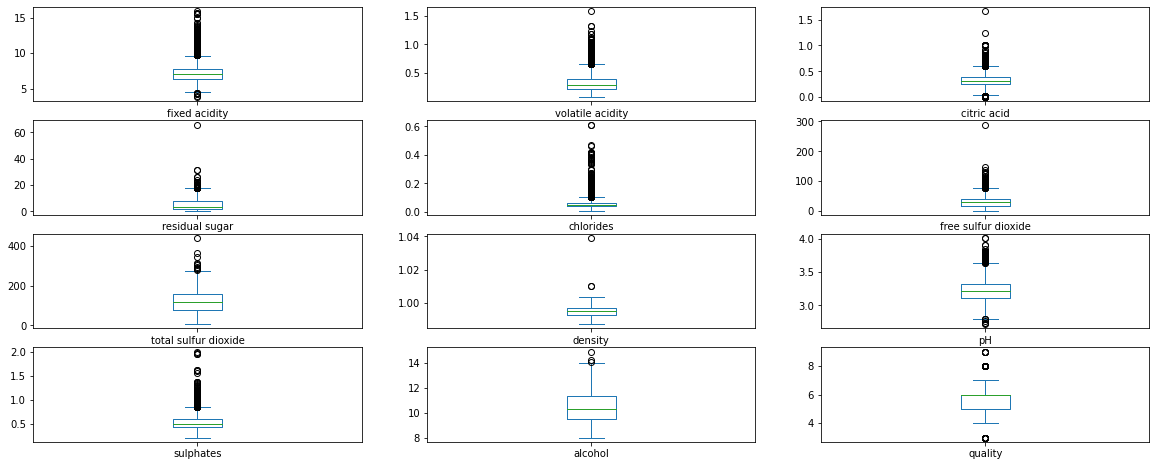

In [16]:
df[numerical_columns].plot(kind='box', subplots=True, layout=(4,3), legend=True, figsize=(20,8))
plt.show()

In [17]:
def outlier_removal(feature):
    Q1 = df[feature].quantile(0.25)
    Q2 = df[feature].quantile(0.75)
    IQR = Q2 - Q1
    upper = Q2 + (1.5*IQR)
    lower = Q1 - (1.5*IQR)
    new =  df[(df[feature]>=lower) & (df[feature]<=upper)]
    return new

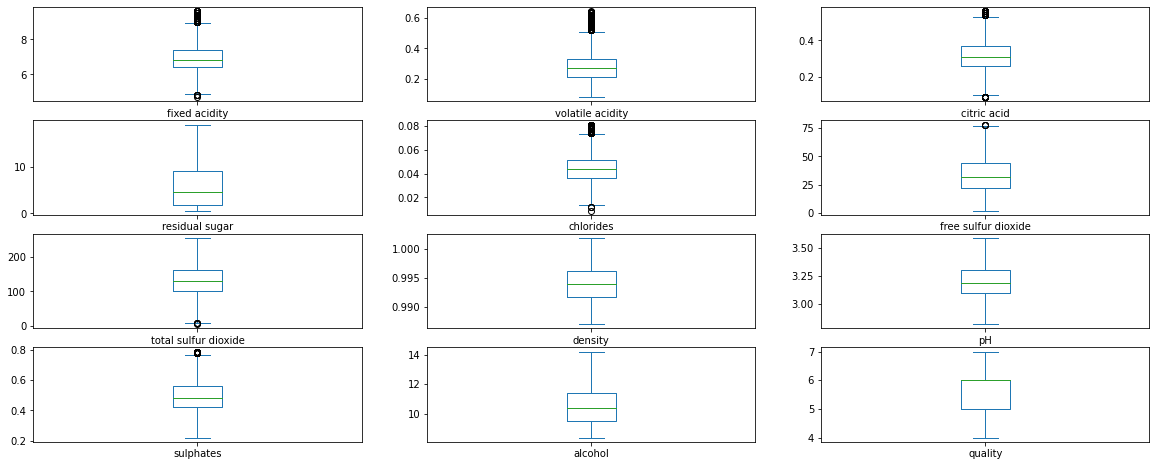

In [18]:
for columns in numerical_columns:
    df = outlier_removal(columns)
    
df[numerical_columns].plot(kind='box', subplots=True, layout=(4,3), legend=True, figsize=(20,8))
plt.show()

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4395 entries, 1 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  4395 non-null   object 
 1   fixed acidity         4395 non-null   float64
 2   volatile acidity      4395 non-null   float64
 3   citric acid           4395 non-null   float64
 4   residual sugar        4395 non-null   float64
 5   chlorides             4395 non-null   float64
 6   free sulfur dioxide   4395 non-null   float64
 7   total sulfur dioxide  4395 non-null   float64
 8   density               4395 non-null   float64
 9   pH                    4395 non-null   float64
 10  sulphates             4395 non-null   float64
 11  alcohol               4395 non-null   float64
 12  quality               4395 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 480.7+ KB


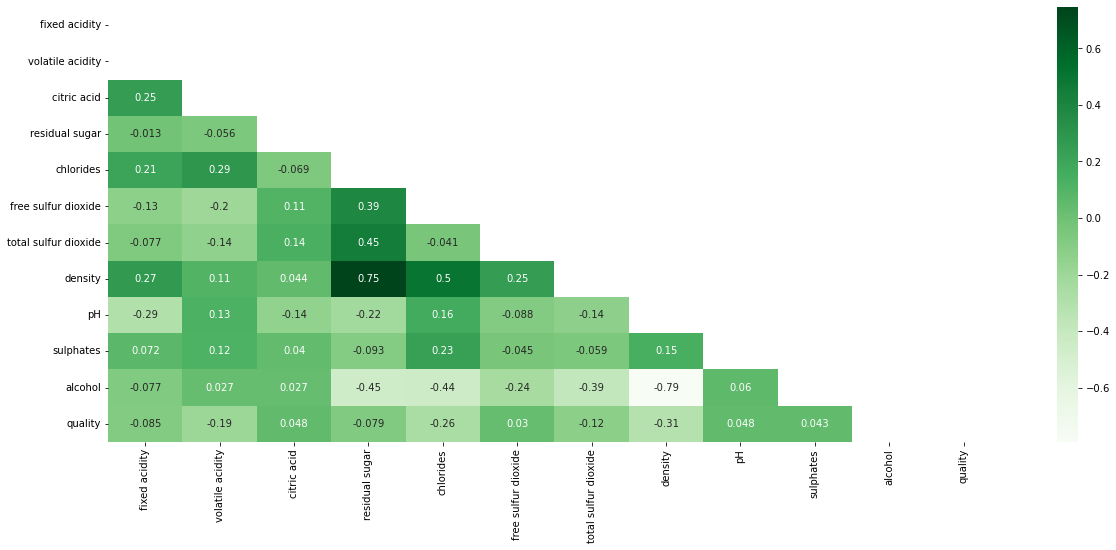

In [20]:
plt.figure(figsize=(20,8))
mask = np.triu(df.corr(),-1)
sns.heatmap(df.corr(), mask=mask, cmap='Greens', annot=True)
plt.show()

In [21]:
bian = LabelBinarizer()
y = bian.fit_transform(df.type)
new = df.copy()
new.type = y

correlation = pd.DataFrame(columns=["Relation of 'type' with", "Pearson's correnation value"])
for index, feature in enumerate(numerical_columns):
    corr,_ = pearsonr(new.type, new[feature])
    correlation.loc[index] = [feature, corr]
correlation = correlation.sort_values("Pearson's correnation value", ascending=False)
    
correlation

,Relation of 'type' with,Pearson's correnation value
6,total sulfur dioxide,0.495899
5,free sulfur dioxide,0.296938
3,residual sugar,0.221497
2,citric acid,0.131523
11,quality,0.059525
10,alcohol,0.010589
7,density,-0.191902
0,fixed acidity,-0.246908
8,pH,-0.292325
9,sulphates,-0.326203


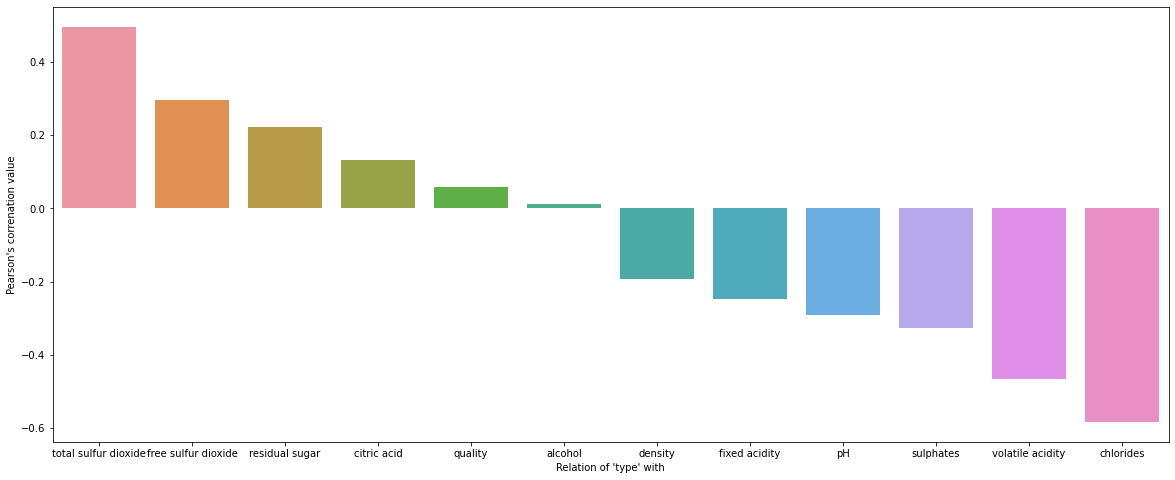

In [22]:
plt.figure(figsize=(20,8))
sns.barplot(x=correlation["Relation of 'type' with"], y=correlation["Pearson's correnation value"])
plt.show()

In [23]:
train, test = train_test_split(df, train_size=0.7, random_state=100, stratify=df.type)

In [24]:
X_train = train[numerical_columns]
y_train = train.type

X_test = test[numerical_columns]
y_test = test.type

In [25]:
y_train.value_counts()

white    2831
red       245
Name: type, dtype: int64

In [26]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_train, y_train)

y_smote.value_counts()

white    2831
red      2831
Name: type, dtype: int64

In [27]:
scaler = MinMaxScaler()
x_smote[numerical_columns] = scaler.fit_transform(x_smote[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

/Users/Amazon/Documents/ml-course/env/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [28]:
lr = LogisticRegression(random_state=22)
folds = KFold(n_splits=5, shuffle=True, random_state=45)
score = cross_val_score(estimator=lr, X=x_smote, y=y_smote, scoring='accuracy', cv=folds, n_jobs=-1)
score.mean()

0.9890503026768421

In [29]:
lr.fit(x_smote, y_smote)
test['predicted_type'] = lr.predict(X_test)

In [30]:
print(classification_report(y_test, test.predicted_type))

              precision    recall  f1-score   support

         red       0.92      0.97      0.94       105
       white       1.00      0.99      1.00      1214

    accuracy                           0.99      1319
   macro avg       0.96      0.98      0.97      1319
weighted avg       0.99      0.99      0.99      1319



In [31]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=22)
folds = KFold(n_splits=5, shuffle=True, random_state=45)
score = cross_val_score(estimator=dt, X=x_smote, y=y_smote, scoring='accuracy', cv=folds, n_jobs=-1)
score.mean()

0.9890509264312826

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=22, max_features= 4, max_depth= 12)
folds = KFold(n_splits=5, shuffle=True, random_state=45)
score = cross_val_score(estimator=rf, X=x_smote, y=y_smote, scoring='accuracy', cv=folds, n_jobs=-1)
score.mean()

0.9954082316873493

In [33]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [34]:
parameters = {'max_depth': [3,5,7,9,12],
             'max_features': [2,3,4,5,9,10]}

rcv = RandomizedSearchCV(estimator=rf, param_distributions=parameters, n_iter=10, n_jobs=-1,
                        scoring='accuracy', cv=folds, verbose=1)
rcv.fit(x_smote, y_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=45, shuffle=True),
                   estimator=RandomForestClassifier(max_depth=12,
                                                    max_features=4,
                                                    random_state=22),
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7, 9, 12],
                                        'max_features': [2, 3, 4, 5, 9, 10]},
                   scoring='accuracy', verbose=1)

In [35]:
rcv.best_params_

{'max_features': 3, 'max_depth': 12}